In [3]:
import sys
sys.path.insert(0, '../../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [34]:
data_dir = ''
growth_exp = glob.glob(f'{data_dir}*growth')
growth_dfs = []
for _, d in enumerate(growth_exp):
#    if int(d.split('_')[0]) > 20190210:
    if glob.glob(f'{d}/output/delta_glucose_GP_summary.csv') != []:
        growth_df = pd.read_csv(glob.glob(f'{d}/output/delta_glucose_GP_summary.csv')[0])
        growth_df['date'] = d.split('_')[0]
        growth_df['temp_C'] = d.split('_')[2][0:2]
        growth_dfs.append(growth_df)
growth_df = pd.concat(growth_dfs)
growth_df['carbon'] = 'glucose'
growth_df['operator'] = 'O2'
growth_df.to_csv('./compiled_growth_summary.csv', index=False)

In [57]:
growth_df = pd.read_csv(f'./compiled_growth_summary.csv')

In [63]:
growth_rate_df = growth_df[
    (growth_df['parameter'] == 'doubling time') | (growth_df['parameter'] == 'max df')].copy()
growth_rate_df.loc[growth_rate_df['parameter'] == 'max df','parameter'] = 'growth_rate'
growth_rate_df.loc[growth_rate_df['parameter'] == 'doubling time','parameter'] = 'doubling_time'

In [64]:
growth_rate_df

,parameter,value,date,temp_C,carbon,operator
0,growth_rate,0.008157,20190213,42,glucose,O2
15,doubling_time,84.973865,20190213,42,glucose,O2
16,growth_rate,0.010125,20190128,37,glucose,O2
31,doubling_time,68.461892,20190128,37,glucose,O2
32,growth_rate,0.004319,20190220,27,glucose,O2
47,doubling_time,160.480579,20190220,27,glucose,O2
48,growth_rate,0.007529,20190212,32,glucose,O2
63,doubling_time,92.066691,20190212,32,glucose,O2
64,growth_rate,0.010287,20190129,37,glucose,O2
79,doubling_time,67.383060,20190129,37,glucose,O2


In [106]:
import matplotlib.ticker as mticker

In [108]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

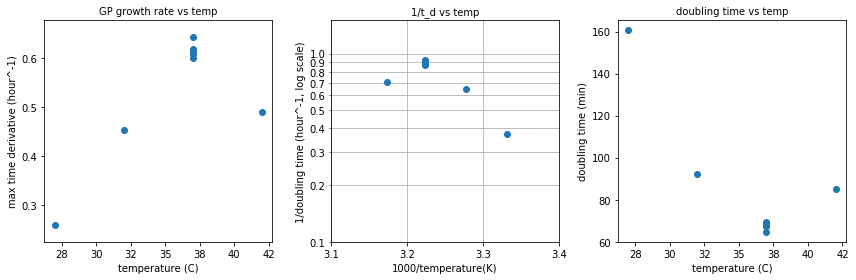

In [135]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].set_title('GP growth rate vs temp', fontsize = 10)
ax[0].scatter(growth_rate_df[growth_rate_df['parameter'] == 'growth_rate']['temp_C'], 
            60*growth_rate_df[growth_rate_df['parameter'] == 'growth_rate']['value'])
ax[0].set_xlabel('temperature (C)')
ax[0].set_ylabel('max time derivative (hour^-1)')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax[1].set_title('1/t_d vs temp', fontsize = 10)
ax[1].semilogy(1000/(growth_rate_df[growth_rate_df['parameter'] == 'growth_rate']['temp_C']+273.15), 
            60/growth_rate_df[growth_rate_df['parameter'] == 'doubling_time']['value'], 'o')
ax[1].grid(True, which="both")
ax[1].set_yticks(np.arange(0.1,1.1,0.1), True)
ax[1].set_xticks(np.arange(3.1,3.5,0.1))
ax[1].set_ylim(0.1, 1.5)
ax[1].set_yticks([], False)
ax[1].yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].set_xlabel('1000/temperature(K)')
ax[1].set_ylabel('1/doubling time (hour^-1, log scale)')

ax[2].set_title('doubling time vs temp', fontsize=10)
ax[2].scatter(growth_rate_df[growth_rate_df['parameter'] == 'doubling_time']['temp_C'], 
            growth_rate_df[growth_rate_df['parameter'] == 'doubling_time']['value'])
ax[2].set_xlabel('temperature (C)')
ax[2].set_ylabel('doubling time (min)')
ax[2].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
fig.tight_layout()
plt.savefig(f'delta_glucose_growth_rate_vs_temperature.png')